In [15]:
from gplearn.genetic import SymbolicRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import graphviz

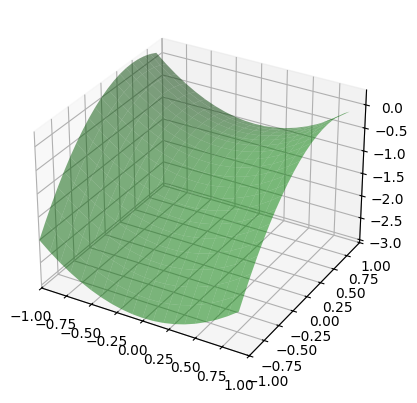

In [6]:
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
plt.show()


In [9]:
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

In [ ]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764      1.12m
   1     9.97          1.70233        5         0.320202         0.624787     48.10s
   2     7.72          1.94456       11         0.239537         0.533148     47.86s
   3     5.41         0.990157        7         0.235676         0.719906     42.45s
   4     4.66         0.894443       11         0.103946         0.103946     38.70s
   5     5.41         0.940242       11         0.060802         0.060802     37.59s
   6     6.78          1.09536       11      0.000781474      0.000781474     34.23s


SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [19]:
print(est_gp._program)

sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


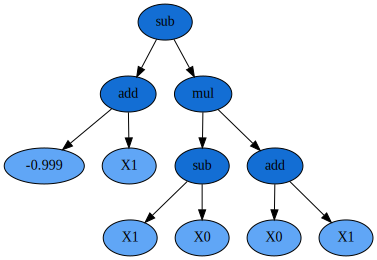

In [17]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph